# 基于BiLSTM的文本情感分析：二分类

参考书籍：《Python深度学习》

### 一、前期准备
#### 1、导入包
- 使用jieba分词处理
- bz2用于解压中文词向量模型
- gensim用于构建文本词向量

In [2]:
import pandas as pd
import os
import numpy as np
import jieba
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
from gensim.models import KeyedVectors
import warnings
import bz2
warnings.filterwarnings('ignore')

#### 2、导入数据集

In [4]:
os.chdir(r'D:\code\Python\WeiboCommentEmotionAnalysis')
data = pd.read_csv(r'weibo_senti_100k.csv',encoding='utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   119988 non-null  int64 
 1   review  119988 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


#### 3、分别获取评论原始文本以及文本极性

In [5]:
data.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [6]:
review = data.review.tolist()              # 获取评论数据
label = data.label.tolist()                # 文本极性,用1和0表示

In [7]:
len(label) == len(review)

True

#### 4、使用bz2模块导入bigram压缩词向量文件

In [9]:
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))           # 解压bz2压缩文件，写入到bigram之中

In [10]:
### 之后将词向量模型转化为gensim的KeyedVectors格式
word_vectors = KeyedVectors.\
        load_word2vec_format('embeddings/sgns.zhihu.bigram', binary=False)

In [11]:
embeddingDim = word_vectors['合肥工业大学'].shape[0]

In [15]:
word_vectors['合肥工业大学'].size

300

In [72]:
word_vectors['生活'].

#### 5、导入tensorflow，之后将训练集向量化

In [16]:
# 使用keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import re
import tensorflow as tf

In [17]:
# 对于训练数据集之中的每一个句子，首先使用jieba分词，之后，在词向量字典之中查找其对应的index。
# 将其添加到train_tokens数组之中

train_tokens = []
for text in review:
    # 首先去除所有的标点符号
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cutList = [i for i in cut]          # 遍历取出generator之中的内容
    for i,word in enumerate(cutList):
        try:
            #
            cutList[i] = word_vectors.key_to_index[word]
        except:
            cutList[i] = 0
    train_tokens.append(cutList)


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\邢智博\AppData\Local\Temp\jieba.cache
Loading model cost 0.468 seconds.
Prefix dict has been built successfully.


In [18]:
train_tokens[0]
len(train_tokens)

119988

In [19]:
len(train_tokens)

119988

#### 6、标准化索引长度
1. 训练数据长度不同无法进行训练
2. 如果使用最长的数组来作为标准长度，那么会造成大量的资源浪费

In [20]:
tokenLens = [len(tokens) for tokens in train_tokens]

In [21]:
np.mean(tokenLens)

33.86023602360236

3. 当标准长度为$\mu + 2 * \sigma$时，可以覆盖$95\%$的数据。也就是正态分布

In [22]:
maxTokens = int(np.mean(tokenLens) + 2 * np.std(tokenLens))
np.sum(np.array(tokenLens) < maxTokens) / len(tokenLens)

0.9578124479114578

In [23]:
maxTokens

78

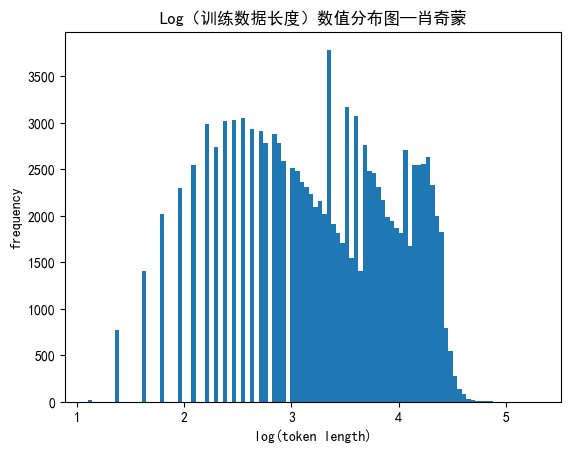

In [24]:
plt.hist(np.log(tokenLens),bins=100)
plt.title('Log（训练数据长度）数值分布图—肖奇蒙')
plt.xlabel('log(token length)')
plt.ylabel('frequency')
plt.show()

#### 7、**反向Tokenize**,方便进行debug.

In [25]:
word_vectors.index_to_key[12]

'人'

In [26]:

def reverseTokenize(tokens):
    """
    该函数用于将tokens数组转圜为对应的句子
    """
    text = ''
    if tokens!=0:
        for i in tokens:
            if tokens!=0:
                text = text + word_vectors.index_to_key[i]
            else:
                text = text + ' '
        return text

In [27]:
## 试试reverseTokenize函数能否正常使用
reverseTokenize(train_tokens[42])

'，动态2010年11月6日在昆明市创业投资引导基金推介暨颁奖晚宴上昆明航空有限公司董事长，中左五从昆明市委常委副市长，手上接过2010泛亚地区，投资潜质，企业证书和奖杯[鼓掌]昆明航空成为500，报名企业中唯一一家获奖的航空企业[礼花]http:，'

In [28]:
review[42]

'#昆航动态#2010年11月6日，在昆明市创业投资引导基金推介暨颁奖晚宴上，昆明航空有限公司董事长王清民（图中左五）从昆明市委常委、副市长刘光溪手上接过#2010泛亚地区最具投资潜质十强企业#证书和奖杯。[鼓掌] 昆明航空成为500多家报名企业中唯一一家获奖的航空企业。[礼花] http://sinaurl.cn/h4QFmF'

In [29]:
# len(word_vectors)

`index_to_key[i]`获取第i个元素对应的中文词汇
`word_vectors[i]`获取中文词汇对应的词向量

#### 8、取word_vectors之中的前五万个作为我们所需要使用的词向量

In [30]:
MAX_WORDS = 50_000
embeddingMatrix = np.zeros((MAX_WORDS,embeddingDim))

for i in range(MAX_WORDS):
    embeddingMatrix[i,:] = word_vectors[word_vectors.index_to_key[i]]

In [31]:
embeddingMatrix.dtype

dtype('float64')

In [32]:
embeddingMatrix = embeddingMatrix.astype('float32')     # float64类型的运算量、性能要求过大。此处转换为float32
embeddingMatrix.shape

(50000, 300)

In [33]:
## 检查index是否一一对应
np.sum(word_vectors[word_vectors.index_to_key[0]] == embeddingMatrix[0,:])

300

#### 9、**padding和truncating**
由于文本转换为tokens以后,每一串索引的长度并不相等,所以,为了方便模型的训练,我们在此将其长度进行标准化
对于长度不满标准长度的数据,在文本索引的前边填充0

In [34]:
"""
该函数实现矩阵对其操作
"""
trainPad = pad_sequences(train_tokens,maxlen = maxTokens,padding = 'pre',truncating = 'pre')
trainPad.shape


(119988, 78)

In [35]:
trainPad[:10]

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      3,      0,      3,
          2386,      1,    814,     25,    622,    233,     42,      0,
           940,   2615,   1261,    233,     42,   1046,   1261,    233,
            42,   1046,   1261,    233,     42,   1046],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
       

In [36]:
trainPad[trainPad >= MAX_WORDS] = 0         #由于我们只保留了前五万个词向量组，所以，如果在训练集中，如果有单词的index>=50000，需要将其替换为0

In [37]:
IndexArray = np.array(label)
type(IndexArray)

numpy.ndarray

#### 10、分割训练集与数据集

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(trainPad,
                                                    IndexArray,
                                                    test_size=0.2,
                                                    random_state=12
                                                    )

### 二、构建模型
尝试了三种RNN模型：
1. GRU
2. LSTM
3. BiLSTM

#### 1、GRU

**创建测试模型,向模型之中添加LTSM模型**



In [40]:
from keras.layers import GRU

In [41]:
model = Sequential()
model.add(Embedding(MAX_WORDS,          # 50000
                    embeddingDim,       # 300
                    weights=[embeddingMatrix],      # 权重
                    input_length=maxTokens,         # 输入字符串tokens的长度
                    trainable=False))   
layers1 = GRU(32,return_sequences=True)
model.add(layers1)
model.add(GRU(units=16, return_sequences = False,input_dim=2))

In [42]:
model.add(Dense(1, activation='sigmoid'))        
optimizer = Adam(lr=1e-3)      # 使用Adam优化器,学习率为1e-3

In [43]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])       # 报错是因为混用了tensorflow和keras的接口

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 300)           15000000  
                                                                 
 gru (GRU)                   (None, 78, 32)            32064     
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 15034481 (57.35 MB)
Trainable params: 34481 (134.69 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


#### 2、LSTM

In [45]:
model2 = Sequential()
model2.add(Embedding(MAX_WORDS,          # 50000
                    embeddingDim,       # 300
                    weights=[embeddingMatrix],      # 权重
                    input_length=maxTokens,         # 输入字符串tokens的长度
                    trainable=False))   
layers2 = LSTM(32,return_sequences=True)
model2.add(layers1)
model2.add(LSTM(units=16, return_sequences = False))

In [46]:
model2.add(Dense(1, activation='sigmoid'))        
optimizer = Adam(lr=1e-3)      # 使用Adam优化器,学习率为1e-3

In [47]:
model2.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])       # 报错是因为混用了tensorflow和keras的接口


In [48]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 300)           15000000  
                                                                 
 gru (GRU)                   (None, 78, 32)            32064     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 15035217 (57.35 MB)
Trainable params: 35217 (137.57 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


#### 3、BiLSTM

In [49]:
model3 = Sequential()
model3.add(Embedding(MAX_WORDS,          # 50000
                    embeddingDim,       # 300
                    weights=[embeddingMatrix],      # 权重
                    input_length=maxTokens,         # 输入字符串tokens的长度
                    trainable=False))   
layers3 = Bidirectional(LSTM(32,return_sequences=True))
model3.add(layers1)
model3.add(LSTM(units=16, return_sequences = False))

In [50]:
model3.add(Dense(1, activation='sigmoid'))        
optimizer = Adam(lr=1e-3)      # 使用Adam优化器,学习率为1e-3

In [51]:
model3.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])       # 报错是因为混用了tensorflow和keras的接口

In [52]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 78, 300)           15000000  
                                                                 
 gru (GRU)                   (None, 78, 32)            32064     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 15035217 (57.35 MB)
Trainable params: 35217 (137.57 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


保存训练好的参数

In [53]:
path_checkpoint = 'sentiment_checkpoint.keras'    # 建立储存权重的文件夹
checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                monitor='val_loss',
                                verbose=1,
                                save_weights_only=True,            
                                save_best_only=True)

In [54]:
# 加载已训练模型
# try:
#     model.load_weights(path_checkpoint)
# except Exception as error:
#     print("Error trying to load checkpoint.")
#     print(error)

In [55]:
# 定义early stopping,当验证集的loss不再下降时,停止训练
earlystopping = EarlyStopping(monitor='val_loss',
                                patience=3, verbose=1)
                                

In [56]:
# 自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                min_lr=1e-5,
                                patience=0,
                                verbose=1)

In [57]:
# 定义回调函数
callbacks = [
    earlystopping,
    checkpoint,
    reduce_lr
]

### 三、训练模型与测试

#### 1、GRU

In [58]:
history = model.fit(x_train,
            y_train,
            validation_split=0.1,
            epochs=20,
            batch_size=128,
            callbacks=callbacks)

Epoch 1/20
675/675 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9626
Epoch 1: val_loss improved from inf to 0.05199, saving model to sentiment_checkpoint.keras
675/675 [==============================] - 33s 45ms/step - loss: 0.1082 - accuracy: 0.9626 - val_loss: 0.0520 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 2/20
674/675 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9828
Epoch 2: val_loss improved from 0.05199 to 0.04155, saving model to sentiment_checkpoint.keras
675/675 [==============================] - 28s 41ms/step - loss: 0.0442 - accuracy: 0.9828 - val_loss: 0.0416 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9830
Epoch 3: val_loss improved from 0.04155 to 0.04069, saving model to sentiment_checkpoint.keras
675/675 [==============================] - 28s 42ms/step - loss: 0.0405 - accuracy: 0.9830 - val_loss: 0.0407 - val_accuracy: 0.9830 - lr: 

In [59]:
result = model.evaluate(x_test, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

750/750 [==============================] - 6s 8ms/step - loss: 0.0411 - accuracy: 0.9825
Accuracy: 98.25%


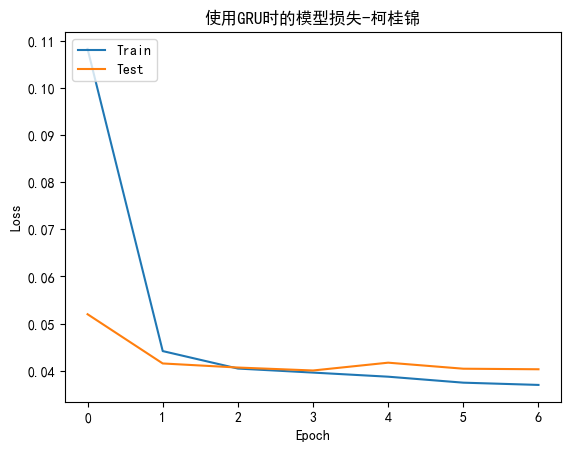

In [60]:
# 绘制训练 & 验证的损失值

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('使用GRU时的模型损失-柯桂锦')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

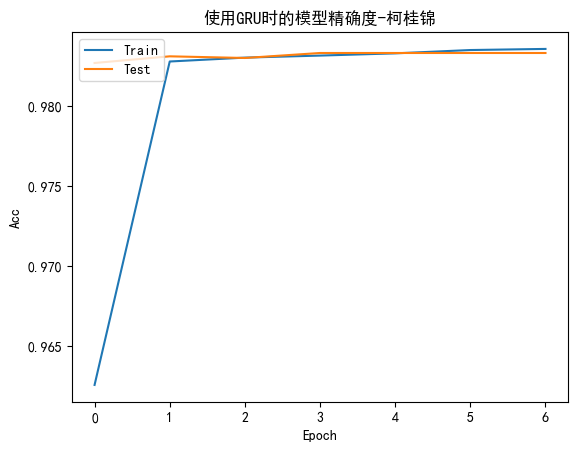

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('使用GRU时的模型精确度-柯桂锦')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [62]:
history.history

{'loss': [0.10821951925754547,
  0.044177085161209106,
  0.04047497734427452,
  0.039619408547878265,
  0.038748156279325485,
  0.037483058869838715,
  0.03700551018118858],
 'accuracy': [0.962565541267395,
  0.9827991127967834,
  0.9830422401428223,
  0.9831695556640625,
  0.9833084344863892,
  0.9835168123245239,
  0.9835862517356873],
 'val_loss': [0.051987484097480774,
  0.04155413806438446,
  0.04069122299551964,
  0.04006453976035118,
  0.04172027111053467,
  0.04044109582901001,
  0.04032326862215996],
 'val_accuracy': [0.9827065467834473,
  0.983123242855072,
  0.9830190539360046,
  0.9833316206932068,
  0.9833316206932068,
  0.9833316206932068,
  0.9833316206932068],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005, 1.0000001e-05]}

#### 2、LSTM

In [63]:
history2 = model2.fit(x_train,
                    y_train,
                    validation_split=0.1,
                    epochs=20,
                    batch_size=128,
                    callbacks=callbacks)
result = model2.evaluate(x_test, y_test)
print("Accuracy: {0:.2%}".format(result[1]))
# 绘制训练 & 验证的损失值

Epoch 1/20
674/675 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9729
Epoch 1: val_loss did not improve from 0.04006
675/675 [==============================] - 29s 39ms/step - loss: 0.0876 - accuracy: 0.9729 - val_loss: 0.0450 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 2/20
674/675 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9830
Epoch 2: val_loss did not improve from 0.04006
675/675 [==============================] - 27s 39ms/step - loss: 0.0420 - accuracy: 0.9830 - val_loss: 0.0414 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9833
Epoch 3: val_loss did not improve from 0.04006

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
675/675 [==============================] - 26s 38ms/step - loss: 0.0398 - accuracy: 0.9833 - val_loss: 0.0423 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/20
675/675 [==============================] - E

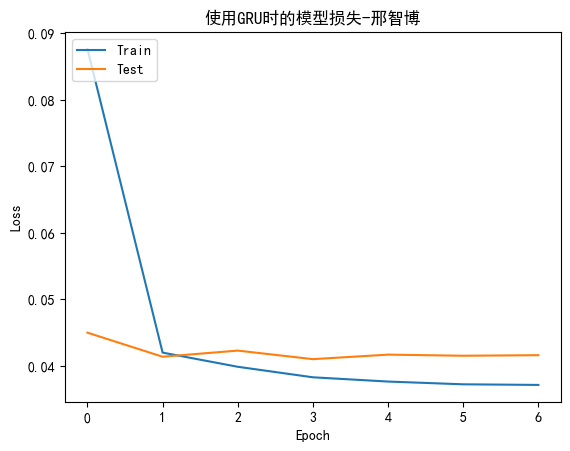

In [64]:

plt.rcParams["font.sans-serif"] = ["SimHei"]  #设置字体
plt.rcParams["axes.unicode_minus"] = False  #该语句解决图像中的“-”负号的乱码问题
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('使用GRU时的模型损失-邢智博')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

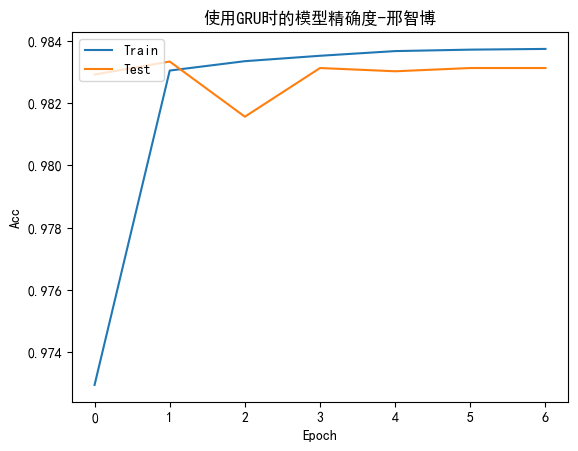

In [65]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('使用GRU时的模型精确度-邢智博')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 3、BiLSTM

In [66]:
history3 = model3.fit(x_train,
                    y_train,
                    validation_split=0.1,
                    epochs=20,
                    batch_size=128,
                    callbacks=callbacks)
result = model3.evaluate(x_test, y_test)
print("Accuracy: {0:.2%}".format(result[1]))
# 绘制训练 & 验证的损失值

Epoch 1/20
675/675 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9796
Epoch 1: val_loss did not improve from 0.04006
675/675 [==============================] - 28s 37ms/step - loss: 0.0699 - accuracy: 0.9796 - val_loss: 0.0423 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9833
Epoch 2: val_loss did not improve from 0.04006
675/675 [==============================] - 26s 39ms/step - loss: 0.0398 - accuracy: 0.9833 - val_loss: 0.0417 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9835
Epoch 3: val_loss did not improve from 0.04006

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
675/675 [==============================] - 25s 37ms/step - loss: 0.0382 - accuracy: 0.9835 - val_loss: 0.0418 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 4/20
674/675 [============================>.] - E

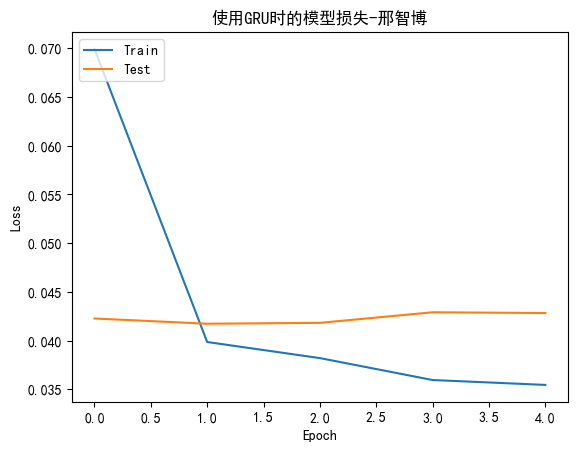

In [67]:

plt.rcParams["font.sans-serif"] = ["SimHei"]  #设置字体
plt.rcParams["axes.unicode_minus"] = False  #该语句解决图像中的“-”负号的乱码问题
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('使用GRU时的模型损失-邢智博')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

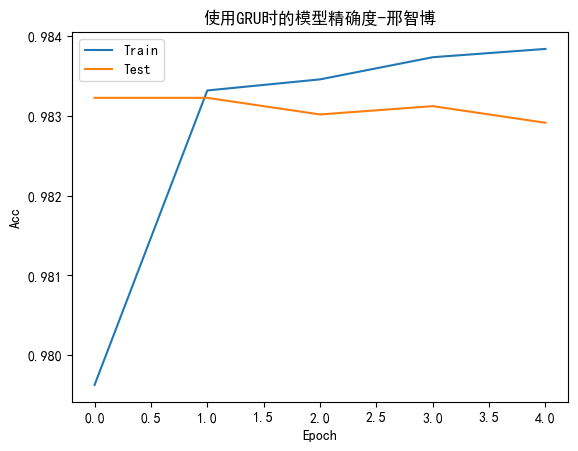

In [68]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('使用GRU时的模型精确度-邢智博')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 四、模型应用
接下来输入文本爬取的文本进行测试
**此函数用于获取文本的极性**


In [69]:
import re
EmtionList = []
def getSentiment(comment,obj):
    # print(comment)
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",comment)
    cut = jieba.cut(text)
    cut = [i for i in cut]
    for i,word in enumerate(cut):
        try:
            cut[i] = word_vectors.key_to_index[word]
            if cut[i] >= MAX_WORDS:
                cut[i] = 0
        except KeyError:
            cut[i] = 0
    tokens = pad_sequences([cut], maxlen=maxTokens,
                            padding='pre', truncating='pre')
    # 和此前预处理的步骤一样,这部分进行对文本的预处理
    result = obj.predict(tokens)
    EmtionList.append(result)
    # if result[0] >= 0.5:
    #     print('{0}是Positive,估值为{1}'.format(comment,result[0]))
    # else:
    #     print('{0}情绪偏向Negative,估值为{1}'.format(comment,result[0]))

**读取文件**

In [70]:
import os
# os.chdir(r'C:\Users\moonchild\OneDrive\MathandModel\NLP\WeiboCrapperAndEmotionAnalysis')
resList = []
with open(r'output/20230423/bilibili.txt','r',encoding='utf-8') as res:
    for i in res:
        resList.append(i)

In [71]:
for comment in resList:
    getSentiment(comment,model)

1/1 [==============================] - 0s 15ms/step


KeyboardInterrupt: 

In [ ]:
EmotionList1 = [emtion[0][0] for emtion in EmtionList]

In [ ]:
for comment in resList:
    getSentiment(comment,model2)
EmotionList2 = [emotion[0][0] for emotion in EmtionList]

In [ ]:
for comment in resList:
    getSentiment(comment,model3)
EmotionList3 = [emotion[0][0] for emotion in EmtionList]

### 五、结果可视化

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题


plt.hist(EmotionList1,bins=200)
plt.xlabel('情感倾向')
plt.ylabel('频数')
plt.title("Bili评论区中关于该话题的情感倾向-曾跃鹏")
plt.show()

In [ ]:
plt.hist(EmotionList2,bins=200)
plt.xlabel('情感倾向')
plt.ylabel('频数')
plt.title("Bili评论区中关于该话题的情感倾向-曾跃鹏")
plt.show()

In [ ]:
plt.hist(EmotionList3,bins=200)
plt.xlabel('情感倾向')
plt.ylabel('频数')
plt.title("Bili评论区中关于该话题的情感倾向-曾跃鹏")
plt.show()



对于这个list，我们将$[0.03]$区间的内容判断为neg，将$[0.3,0.6]$的内容判断为中中性，$[0.6,1]$的内容判断为positive。

In [ ]:
neg,median,pos = 0,0,0
for emotion in EmtionList:
    if emotion<0.3:
        neg+=1
    elif emotion>=0.3 and emotion<0.6:
        median+=1
    else:
        pos+=1
neg,median,pos = neg/len(EmtionList),median/len(EmtionList),pos/len(EmtionList)

In [ ]:
plt.pie(np.array([neg,median,pos]),labels=['负面','中性','正面'])
plt.title('Bili评论区中情感分布饼图-曾跃鹏')

In [ ]:
import os
os.chdir(r'D:\code\WeiboCommentEmotionAnalysis')

with open("output/20230423/bilibili.txt",'r',encoding='utf-8') as file:
    li = file.readlines()
li = [i.strip() for i in li]

In [ ]:
string  = ''
for i in li:
    string +=i


In [ ]:
import jieba
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS



wordList = " ".join(jieba.lcut(string))

cloud = WordCloud(
    width=2000,height=1600
    , background_color="white"
    , mode='RGB'
    # , mask=backgroundImg
    , max_words=1000
    , max_font_size=350
    , font_path=r'C:\Windows\Fonts\simhei.ttf'  # 必须要添加中文字体地址,否则会生成方框
    , relative_scaling=0.6
    , random_state=50
    ,colormap='summer'
    , stopwords=STOPWORDS.update(
        ['我', '了', '在', '和', '是', '作者', '中', '那', '也', '里', '没有', '着', '都', '但', '被', '到', '与', '使',
         '很', '像', '说', '啊', '把', '又', '他', '之', 'w', 'W', '的', '你们', '你', '我们', '上', '而', '这','南翔','可以','doge','就','系列','视频','东西','人','吗','打','call','热词','真的','博主','用','美食','做','不是' ,'吧','吃','至尊','脱单','为什么','至尊','看','然后','大','辣','眼睛','不','看','主','现在','会','什么','主','就是','哭','笑','能','知道','来','所以','好像','因为','区','个','没','朋友','不能','还','以为','有','想','居然','已经','出来','再','才','这个','这次','喜欢','有','屁','看到','给','这种','一','cry','帮忙','下','下次','自己','一定','这样','太','让','吃瓜','需要','觉得','找','呢','每次','更多','剩下','有人','叫','直接','还是','真','一直','呲牙','后面','需要','觉得','代替'
         '一个','好','可能','下期','tv','从','对','买','滑稽','一个','怎么','那个','薅','羊毛','热乎','谁','要','做饭','回复','可能','心心','奢侈品','评论','三连','不爱','吃饭','啦','这么','得','眼','斜眼','还有','大大','应该','不会','跟','或者','去','知识','的话','烤全羊','完','啥','手工','怎么样','最后','是不是','关注','忘','写','开始','到底','变成','呲牙','大哭','一只'])
).generate(wordList)

plt.imshow(cloud)
plt.axis("off")
plt.title("词云-张洛歌")
plt.show()

cloud.to_file("output\\20230423\\bilibili_cloud.jpg")